# MP Assignment Behavior Cloning

Thao Dang, HS Esslingen

![Gymnasium car racing environment](https://gymnasium.farama.org/_images/car_racing.gif)

In this assignment, you will use behavior cloning to run a car in gymnasiums car racing environment. The assignment is based on a course of Andreas Geiger at the University of Tübingen. Pytorch will be used for the behavior cloning network, so you should run this notebook with a GPU.
To enable GPU's in colab, select 
```bash
"Runtime" > “Change runtime type” > "T4 GPU"
```
after you uploaded the notebook file to colab.

We will use the discrete version of the car racing environment. A race car should drive a random environment as fast as possible, where potential discrete actions comprise (a combination of)
- do nothing
- steer left
- steer right
- gas
- brake

Expert demonstrations are provided, though you can later record your own demos as an optional exercise (but not in colab!). The assignemt is structured as follows:
1. Test gymnasium environment
2. Analyse the expert demonstrations
3. Design and train the behavior cloning network with pytorch
4. Evaluate the network
5. Optional extensions

## Test gymnasium environment

First, upload the required additional files to colab (file symbol icon on the left side bar):
- utils.py 
- training.py 
- demos_no_braking.npz

Then, install the necessary modules:

In [1]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
import sys
import numpy as np
import torch
import gymnasium as gym
from dataclasses import dataclass, field
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from utils import *
from training import train

# torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
# The flag below controls whether to allow TF32 on matmul. This flag defaults to True.
torch.backends.cuda.matmul.allow_tf32 = False
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = False

# remove old video files (if any)
if os.path.exists('output'):
    os.system('rm -f output/*.mp4')

## Test gymnasium environment

The following code starts the car racing environment, runs some random actions, and creates a video of the trial. Make sure that everything is installed properly and the video is created.

In [2]:
env = SDC_Wrapper(gym.make("CarRacing-v3", render_mode = "rgb_array"), remove_score=True)
env = RenderFrame(env, "./output")

observation, info = env.reset()

while True:
  action = env.action_space.sample()
  observation, reward, terminated, truncated, info = env.step(action)

  if terminated or truncated:
    break

env.play()

## Inspect training data

First, we need to have a look at the expert data. The following code loads the data as observations (i.e., the training features) and actions (i.e., our targets).

1. Visualize samples of the features (using ``plt.imshow(...)``) and the corresponding actions.

2. The actions ``action=[steering, acceleration, braking]`` only contain discrete values. Find out which values for the actions occur in the dataset (using ``np.unique``)

In [3]:
data_files = ['demos_no_braking.npz']
observations, actions = load_demonstrations(data_files)

steering:  [-1.  0.  1.]
acceleration:  [0.  0.5]
braking:  [0.]


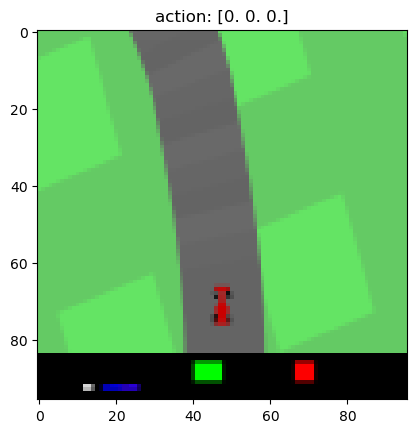

In [4]:
# 1. Visualize the data
# 2. Check the range of the actions

plt.figure()
plt.imshow(observations[100])
plt.title('action: '+str(actions[100]))

actions_np = np.array(actions)
print('steering: ', np.unique(actions_np[:,0]))
print('acceleration: ', np.unique(actions_np[:,1]))
print('braking: ', np.unique(actions_np[:,2]))

3. The actions you have analyzed above are not independent (e.g. accelerate and brake simultaneously does not make sense). So, it's useful to define classes of possible actions, like {steer left}, {steer left and accelerate}, {accelerate}, etc. Based on the numerical values from the previous task, define a full set of discrete action classes, e.g.

```python
    CLASSES = [
            [-1.0, 0.0, 0.0],  # 0: Left
            [-1.0, 0.5, 0.0],  # 1: left with acceleration
            [0.0, 0.0, 0.0],   # 2: straight
            ...
        ]
```

4. Count how many instances of each class are present in the data set. Is the data set well-balanced? What might be the consequences of this?

Classes:
[[-1.   0.   0. ]
 [-1.   0.5  0. ]
 [-1.   0.   0.8]
 [ 1.   0.   0. ]
 [ 1.   0.5  0. ]
 [ 1.   0.   0.8]
 [ 0.   0.   0. ]
 [ 0.   0.5  0. ]
 [ 0.   0.   0.8]]

Number of class instances:
0 :  312.0
1 :  80.0
2 :  0.0
3 :  106.0
4 :  26.0
5 :  0.0
6 :  4283.0
7 :  233.0
8 :  0.0


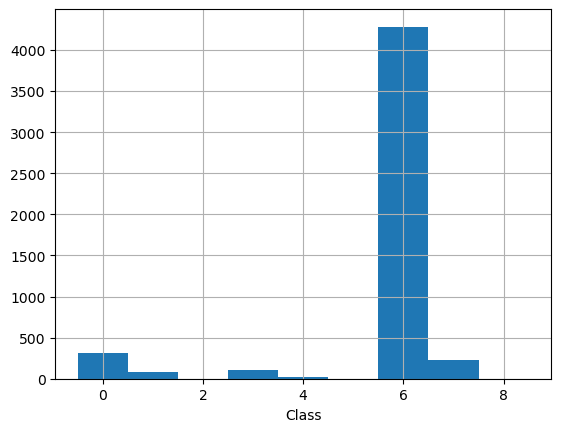

In [5]:
# 3. Define action classes
# 4. Check the distribution of the action classes

CLASSES = [
            [-1.0, 0.0, 0.0],  # 0: Left
            [-1.0, 0.5, 0.0],  # 1: left with acceleration
            [-1.0, 0.0, 0.8],  # 2: left with brakes
            [1.0, 0.0, 0.0],   # 3: right
            [1.0, 0.5, 0.0],   # 4: right with acceleration
            [1.0, 0.0, 0.8],   # 5: right with brakes
            [0.0, 0.0, 0.0],   # 6: straight
            [0.0, 0.5, 0.0],   # 7: straight with acceleration
            [0.0, 0.0, 0.8]    # 8: straight with brakes
        ]

print('Classes:')
print(np.array(CLASSES))

num_classes = np.zeros(len(CLASSES))
for a in actions:
    for idx, c in enumerate(CLASSES):
        if np.array_equal(a, c):
            num_classes[idx] += 1

print('\nNumber of class instances:')
for idx, n in enumerate(num_classes):
    print(idx, ': ', n)

plt.figure()
plt.stairs(num_classes, edges=np.arange(0, len(num_classes)+1)-0.5, fill=True, label='#samples in each class')
plt.grid(True)
plt.xlabel('Class');

## Define Neural Network

1. Design a small first network architecture in the ``ClassificationNetwork`` below. Start with two to three convolutional layers, 
followed by two or three fully connected layers (linear layers) to extract the output vector. Let each layer be followed by a ReLU as the non-linear activation (see code
snippets below). Add your code in the ``__init__`` and ``forward`` function.

    ```python
    self.cnn_layers = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, filter_size, stride),
        torch.nn.LeakyReLU(negative_slope=0.2))

    self.fcn_layers = torch.nn.Sequential(
        torch.nn.Linear(in_size, out_size),
        torch.nn.LeakyReLU(negative_slope=0.2))
    ````

2. You can visualize your network architecture with the code below.

In [6]:
class ClassificationNetwork(torch.nn.Module):
    def __init__(self):
        """
        Implementation of the network layers. The image size of the input
        observations is 96x96 pixels.
        """
        super().__init__()

        # setting device on GPU if available, else CPU
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.classes = CLASSES # as defined above
        
        # DEFINE YOUR LAYERS HERE
        self.include_sensor_values = False

        self.cnn_layers = torch.nn.Sequential(
            torch.nn.Conv2d(3, 4, 5, stride=2),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.BatchNorm2d(4),
            torch.nn.Conv2d(4, 8, 5, stride=2),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.BatchNorm2d(8),
            torch.nn.Conv2d(8, 16, 5, stride=2),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.BatchNorm2d(16),
            torch.nn.Conv2d(16, 32, 3, stride=1),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.BatchNorm2d(32),
        ).to(device)

        self.fcn_layers = torch.nn.Sequential(
            torch.nn.Linear(32 * 7 * 7, 128),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.BatchNorm1d(128),
            torch.nn.Linear(128, 64),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.BatchNorm1d(64)
        ).to(device)

        if self.include_sensor_values:
            fused_features_size = 64 + 7 # 7 sensor values
        else:
            fused_features_size = 64
            
        self.output_layers = torch.nn.Sequential(
            torch.nn.Linear(fused_features_size, 16),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.BatchNorm1d(16),
            torch.nn.Linear(16, 9)
        ).to(device)

    def forward(self, observation):
        """
        The forward pass of the network. Returns the prediction for the given
        input observation.
        observation:   torch.Tensor of size (batch_size, 96, 96, 3)
        return         torch.Tensor of size (batch_size, C)
        """
        batch_size = observation.shape[0]

        # INSERT YOUR CODE HERE
        if self.include_sensor_values:
            speed, abs_sensors, steering, gyroscope = self.extract_sensor_values(
                observation, batch_size
            )
            
        obs = observation.reshape(batch_size, 3, 96, 96)
        cnn = self.cnn_layers(obs).reshape(batch_size, -1)
        fcn = self.fcn_layers(cnn)
        
        if self.include_sensor_values:
            fused_features = torch.cat(
                (fcn, speed, abs_sensors, steering, gyroscope), 1
            )
        else:
            fused_features = fcn
        return self.output_layers(fused_features)

    def actions_to_classes(self, actions):
        """
        For a given set of actions map every action to its corresponding
        action-class representation. Every action is represented by a 1-dim vector
        with the entry corresponding to the class number.
        actions:        python list of N torch.Tensors of size 3
        return          python list of N torch.Tensors of size 1
        """
        return [
            torch.Tensor(
                [
                    int(
                        torch.prod(action == this_class)
                    )  # calculate the product of the elements in boolean tensor and converts them to a list
                    for this_class in torch.Tensor(self.classes)
                ]
            )
            for action in actions
        ]

    def scores_to_action(self, scores):
        """
        Maps the scores predicted by the network to an action-class and returns
        the corresponding action [steer, gas, brake].
                        C = number of classes
        scores:         python list of torch.Tensors of size C
        return          (float, float, float)
        """
        x, class_number = torch.max(
            scores[0], dim=0
        )  # Why scores[0] only?? # Finds the max from the 9X1 column vector
        steer, gas, brake = self.classes[
            class_number
        ]  # Uses the classes you defined in init function to get back the appropriate values for steer,gas,brake
        return steer, gas, brake

    def extract_sensor_values(self, observation, batch_size):
        # just approximately normalized, usually this suffices.
        # can be changed by you
        speed_crop = observation[:, 84:94, 12, 0].reshape(batch_size, -1)
        speed = speed_crop.sum(dim=1, keepdim=True) / 255 / 5

        abs_crop = observation[:, 84:94, 18:25:2, 2].reshape(batch_size, 10, 4)
        abs_sensors = abs_crop.sum(dim=1) / 255 / 5

        steer_crop = observation[:, 88, 38:58, 1].reshape(batch_size, -1) / 255 / 10
        steer_crop[:, :10] *= -1
        steering = steer_crop.sum(dim=1, keepdim=True)

        gyro_crop = observation[:, 88, 58:86, 0].reshape(batch_size, -1) / 255 / 5
        gyro_crop[:, :14] *= -1
        gyroscope = gyro_crop.sum(dim=1, keepdim=True)

        return speed, abs_sensors.reshape(batch_size, 4), steering, gyroscope
    
    
model = ClassificationNetwork()
print(model)
    

ClassificationNetwork(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(5, 5), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(4, 8, kernel_size=(5, 5), stride=(2, 2))
    (4): LeakyReLU(negative_slope=0.2)
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0.2)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (10): LeakyReLU(negative_slope=0.2)
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fcn_layers): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

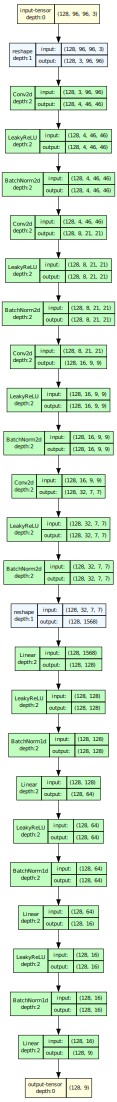

In [7]:
from torchview import draw_graph
import graphviz

# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.format = 'png'
model_graph1 = draw_graph(ClassificationNetwork(), input_size=(128, 96, 96, 3))
model_graph1.visual_graph

## Run training

1. Read and modify the ``train.py`` file. Use the torch ``CrossEntropyLoss`` (combines LogSoftmax and NLLLoss - negative log likelihood loss)
to calculate the loss. Adjust the number of classes you defined above.

2. You can evaluate the results with the two cells in the Evaluation chapter below. ``evaluate`` generates a video of a random scenario. ``calculate_score``computes a mean score over a fixed set of scenarios.

3. Now you can do some hyperparameter optimization. What are learning rate, batch size, and number of epochs? Can you get better performance with other values?
You may change the network architecture and use maybe dropout or batch normalization. In addition, you may set class weights in the ``CrossEntropyLoss`` function to counter potentially unbalanced datasets.

In [ ]:
@dataclass
class DefaultArguments:
    """Genereal arguments for our training."""
    agent_load_path: str = "agent.pth" # Path to the .pth file of the trained agent
    agent_save_path: str = "agent.pth" # Save path of the trained model
    training_data_path: list = field(default_factory=lambda: ["demos_no_braking.npz"]) # training data files
    lr: float = 1e-3 #1e-2 # Learning rate
    batch_size: int = 128 # Batch size
    nr_epochs: int = 75 # Number of training epochs
    no_display: bool = False # disable video output

args = DefaultArguments()

train(args.training_data_path, args.agent_save_path, args)

Epoch     1	[Train]	loss: 39.452721 	ETA: +39.392511s
Epoch     2	[Train]	loss: 36.878136 	ETA: +37.918297s
Epoch     3	[Train]	loss: 35.326103 	ETA: +37.495296s
Epoch     4	[Train]	loss: 34.100193 	ETA: +37.036808s
Epoch     5	[Train]	loss: 33.118347 	ETA: +36.549345s
Epoch     6	[Train]	loss: 32.392231 	ETA: +36.222407s
Epoch     7	[Train]	loss: 31.625509 	ETA: +35.684973s
Epoch     8	[Train]	loss: 30.834469 	ETA: +35.266683s
Epoch     9	[Train]	loss: 30.088036 	ETA: +34.743520s
Epoch    10	[Train]	loss: 29.572962 	ETA: +34.138906s
Epoch    11	[Train]	loss: 29.184895 	ETA: +33.551132s
Epoch    12	[Train]	loss: 28.988678 	ETA: +33.038329s
Epoch    13	[Train]	loss: 28.736053 	ETA: +32.467943s
Epoch    14	[Train]	loss: 28.722591 	ETA: +31.904949s
Epoch    15	[Train]	loss: 28.422907 	ETA: +31.302346s
Epoch    16	[Train]	loss: 28.328871 	ETA: +30.744851s
Epoch    17	[Train]	loss: 28.259241 	ETA: +30.185328s
Epoch    18	[Train]	loss: 28.275068 	ETA: +29.677455s
Epoch    19	[Train]	loss: 28

## Evaluate result

In [12]:
def evaluate(args, trained_network_file):
    """
    evaluate the trained network on random environment and create video
    """
    # setting device on GPU if available, else CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    infer_action = torch.load(trained_network_file, map_location=device)
    infer_action.eval()

    env = SDC_Wrapper(gym.make("CarRacing-v3", render_mode = "rgb_array"), remove_score=True)
    env = RenderFrame(env, "./output", auto_release=False)
    observation, info = env.reset()

    reward_per_episode = 0
    for t in range(600):
        action_scores = infer_action(torch.Tensor(
            np.ascontiguousarray(observation[None])).to(device))

        action = infer_action.scores_to_action(action_scores)
        observation, reward, terminated, truncated, info = env.step(action)
        reward_per_episode += reward
        
        if terminated or truncated:
            break

    print('total reward %f' % (reward_per_episode))
    env.release()
    env.play()

    
evaluate(args, 'agent.pth')

total reward 232.957746


In [13]:
def calculate_score(args, trained_network_file):
    """
    Evaluate the performance of the network on some standard test environments.
    """
    # setting device on GPU if available, else CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    infer_action = torch.load(trained_network_file, map_location=device)
    infer_action.eval()

    env = SDC_Wrapper(gym.make('CarRacing-v3', render_mode='human'), remove_score=True)

    seeds = [22597174, 68545857, 75568192, 91140053, 86018367,
             49636746, 66759182, 91294619, 84274995, 31531469]

    total_reward = 0

    with torch.no_grad():
        for episode, seed in enumerate(seeds):
            observation, info = env.reset(seed=seed)
            reward_per_episode = 0
            for t in tqdm(range(600), leave=False):
                action_scores = infer_action(torch.Tensor(
                    np.ascontiguousarray(observation[None])).to(device))

                steer, gas, brake = infer_action.scores_to_action(action_scores)
                observation, reward, terminated, truncated, info = env.step([steer, gas, brake])
                reward_per_episode += reward
                
                if terminated or truncated:
                    break

            print('episode %d \t reward %f' % (episode, reward_per_episode))
            total_reward += np.clip(reward_per_episode, 0, np.inf)

    print('---------------------------')
    print(' total score: %f' % (total_reward / len(seeds)))
    print('---------------------------')
    env.close()
    

calculate_score(args, 'agent.pth')

  0%|          | 0/600 [00:00<?, ?it/s]

episode 0 	 reward 313.626374


  0%|          | 0/600 [00:00<?, ?it/s]

episode 1 	 reward 302.126246


  0%|          | 0/600 [00:00<?, ?it/s]

episode 2 	 reward 307.003367


  0%|          | 0/600 [00:00<?, ?it/s]

episode 3 	 reward 299.550562


  0%|          | 0/600 [00:00<?, ?it/s]

episode 4 	 reward 285.637584


  0%|          | 0/600 [00:00<?, ?it/s]

episode 5 	 reward 307.132867


  0%|          | 0/600 [00:00<?, ?it/s]

episode 6 	 reward 292.542373


  0%|          | 0/600 [00:00<?, ?it/s]

episode 7 	 reward 326.029412


  0%|          | 0/600 [00:00<?, ?it/s]

episode 8 	 reward 316.425856


  0%|          | 0/600 [00:00<?, ?it/s]

episode 9 	 reward 265.878594
---------------------------
 total score: 301.595323
---------------------------


## Optional extensions and improvements

There is no definite solution to this assignment and there are many ways in which the results could potentially be improved. Here are some suggestions you could try:

1. There is a function ``extract_sensor_values`` that retrieves some additional values from the image. Check what this function is doing and include its results as additionals features in the network. How does the performance of the network change?

2. Data augmentation: A common technique in deep learning is the synthetic generation of additional data by augmenting the existing (observation, action) tuples? What augmentation methods can you think of? Implement them. Does the performance change?

3. Record your own data and rerun training. Check the files ``record_demonstrations.py`` and ``environment.yml`` to do this (requires Anaconda on your own PC since recording cannot be run in a jupyter notebook).

4. Formulate the problem as a regression problem instead of a classification problem. You can change the setup by adding the option ``continuous=False`` in the ``gym.make`` command and a lot of other modifications in the notebook and training script.

5. ... and a lot more... If you find very good solutions or solutions that you're proud of, please send them to me!